In [1]:
%matplotlib inline
import os
import time

import skimage 
from skimage.transform import resize
from skimage.exposure import rescale_intensity
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import PIL

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset as torchDataset
import torchvision as tv
from torch.autograd import Variable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Rectangle

import shutil

import pydicom

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.catch_warnings()

gpu_available = True

original_image_shape = 1024

datapath_orig = 'Rsna/'

In [2]:
# 训练集信息
df_train = pd.read_csv('train.csv')
# 测试集信息
df_test = pd.read_csv('test.csv')
df_train.head(7)

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   
5  00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1   
6  00569f44-917d-4c86-a842-81832af98c30    NaN    NaN    NaN     NaN       0   

                          class PatientSex  PatientAge ViewPosition  
0  No Lung Opacity / Not Normal          F        51.0           PA  
1  No Lung Opacity / Not Normal          F        48.0           PA  
2  No Lung Opacity / Not Normal          M        19.0           AP  
3                        Normal          M        28.0           PA  
4                  Lung Opacity          F        32.0           AP  
5                  Lung Opacity          F        32.0           AP  
6  No Lung Opacity / Not Normal          M        54.0           AP

count      9555.000000
mean      77523.448038
std       51807.689206
min        2320.000000
25%       37535.500000
50%       64829.000000
75%      106491.500000
max      371184.000000
Name: box_area, dtype: float64

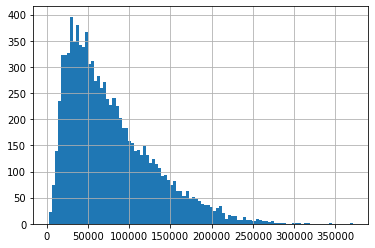

In [3]:
# 查看box分布信息
df_train['box_area'] = df_train['width'] * df_train['height']
df_train['box_area'].hist(bins=100)
df_train['box_area'].describe()

In [4]:
# 创建ID列表，将train分为训练集和验证集
validation_frac = 0.10
min_box_area = 10000

df_train = df_train.sample(frac=1, random_state=42) 
pIds = [pId for pId in df_train['patientId']]

pIds_valid = pIds[ : int(round(validation_frac*len(pIds)))]
pIds_train = pIds[int(round(validation_frac*len(pIds))) : ]
pIds_train=pIds
print(len(pIds_train))

print('{} patient IDs shuffled and {}% of them used in validation set.'.format(len(pIds), validation_frac*100))
print('{} images went into train set and {} images went into validation set.'.format(len(pIds_train), len(pIds_valid)))

# 获取test的ID列表
pIds_test = df_test['patientId']
print('{} patient IDs in test set.'.format(len(pIds_test)))

30227
30227 patient IDs shuffled and 10.0% of them used in validation set.
30227 images went into train set and 3023 images went into validation set.
3000 patient IDs in test set.


In [6]:
# 给出box信息
def get_boxes_per_patient(df, pId):
    boxes = df.loc[df['patientId']==pId][['x', 'y', 'width', 'height']].astype('int').values.tolist()
    return boxes

In [7]:
# 创建box和ID结合的列表
pId_boxes_dict = {}
for pId in df_train.loc[(df_train['Target']==1)]['patientId'].tolist():
    pId_boxes_dict[pId] = get_boxes_per_patient(df_train, pId)
print('{} ({:.1f}%) images have target boxes.'.format(len(pId_boxes_dict), 100*(len(pId_boxes_dict)/len(pIds))))

6012 (19.9%) images have target boxes.


In [8]:
# 归一化
def imgMinMaxScaler(img, scale_range):
    
    warnings.filterwarnings("ignore")
    img = img.astype('float64')
    img_std = (img - np.min(img)) / (np.max(img) - np.min(img))
    img_scaled = img_std * float(scale_range[1] - scale_range[0]) + float(scale_range[0])
    # round at closest integer and transform to integer 
    img_scaled = np.rint(img_scaled).astype('uint8')

    return img_scaled

In [9]:
# 对mask进行弹性变换方便之后训练 
def elastic_transform(image, alpha, sigma, random_state=None):

    assert len(image.shape)==2, 'Image must have 2 dimensions.'

    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant", cval=0) * alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = np.reshape(x+dx, (-1, 1)), np.reshape(y+dy, (-1, 1))
    
    image_warped = map_coordinates(image, indices, order=1).reshape(shape)
    
    return image_warped

In [10]:
# 定义一个数据生成器类
class PneumoniaDataset(torchDataset):

    def __init__(self, root, subset, pIds, predict, boxes, rescale_factor=1, transform=None, rotation_angle=0, warping=False):
        
        self.root = os.path.expanduser(root)
        self.subset = subset
        if self.subset not in ['train', 'test']:
            raise RuntimeError('Invalid subset ' + self.subset + ', it must be one of: \'train\' or \'test\'')
        self.pIds = pIds
        self.predict = predict
        self.boxes = boxes
        self.rescale_factor = rescale_factor
        self.transform = transform
        self.rotation_angle = rotation_angle
        self.warping = warping

        self.data_path = self.root + 'stage_2_'+self.subset+'_images/'
        
    def __getitem__(self, index):
        pId = self.pIds[index]
        img = pydicom.dcmread(os.path.join(self.data_path, pId+'.dcm')).pixel_array
        if (img.shape[0]!=img.shape[1]):
            raise RuntimeError('Image shape {} should be square.'.format(img.shape))
        original_image_shape = img.shape[0]
        image_shape = original_image_shape / self.rescale_factor
        if (image_shape != int(image_shape)):
            raise RuntimeError('Network image shape should be an integer.'.format(image_shape))
        image_shape = int(image_shape)
        img = resize(img, (image_shape, image_shape), mode='reflect')
        img = imgMinMaxScaler(img, (0,255))
        if self.warping:
            img = elastic_transform(img, image_shape*2., image_shape*0.1)
        img = np.expand_dims(img, -1)
        if self.rotation_angle>0:
            angle = self.rotation_angle * (2 * np.random.random_sample() - 1) 
            img = tv.transforms.functional.to_pil_image(img)
            img = tv.transforms.functional.rotate(img, angle, resample=PIL.Image.BILINEAR)
                                            
        if self.transform is not None:
            img = self.transform(img)
        
        if not self.predict:
            target = np.zeros((image_shape, image_shape))
            if pId in self.boxes:
                for box in self.boxes[pId]:
                    x, y, w, h = box
                    x = int(round(x/rescale_factor))
                    y = int(round(y/rescale_factor))
                    w = int(round(w/rescale_factor))
                    h = int(round(h/rescale_factor))
                    target[y:y+h, x:x+w] = 255 
                    target[target>255] = 255 
            target = np.expand_dims(target, -1)   
            target = target.astype('uint8')
            if self.rotation_angle>0:
                target = tv.transforms.functional.to_pil_image(target)
                target = tv.transforms.functional.rotate(target, angle, resample=PIL.Image.BILINEAR)
            if self.transform is not None:
                target = self.transform(target)
            return img, target, pId
        else: 
            return img, pId

    def __len__(self):
        return len(self.pIds)

In [11]:
rescale_factor = 4 
batch_size = 4 
min_box_area = int(round(min_box_area / float(rescale_factor**2)))
transform = tv.transforms.Compose([tv.transforms.ToTensor()])

# 创建dateset
dataset_train = PneumoniaDataset(root=datapath_orig, subset='train', pIds=pIds_train, predict=False, 
                                 boxes=pId_boxes_dict, rescale_factor=rescale_factor, transform=transform,
                                 rotation_angle=3, warping=True)

dataset_valid = PneumoniaDataset(root=datapath_orig, subset='train', pIds=pIds_valid, predict=False, 
                                 boxes=pId_boxes_dict, rescale_factor=rescale_factor, transform=transform,
                                 rotation_angle=0, warping=False)

dataset_test = PneumoniaDataset(root=datapath_orig, subset='test', pIds=pIds_test, predict=True, 
                                boxes=None, rescale_factor=rescale_factor, transform=transform,
                                rotation_angle=0, warping=False)

# 定义dataloader
loader_train = DataLoader(dataset=dataset_train,
                           batch_size=batch_size,
                           shuffle=True) 

loader_valid = DataLoader(dataset=dataset_valid,
                           batch_size=batch_size,
                           shuffle=True) 

loader_test = DataLoader(dataset=dataset_test,
                         batch_size=batch_size,
                         shuffle=False) 

30227 images in train set, 3023 images in validation set, and 3000 images in test set.
Tensor batch size: torch.Size([4, 1, 256, 256])

Image and mask shapes: torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
Patient ID: 4dd92d1d-f5dd-4163-a55f-6a6ef95aa6f0
Image scale: 0.0 - 0.9843137264251709
Target mask scale: 0.0 - 0.0


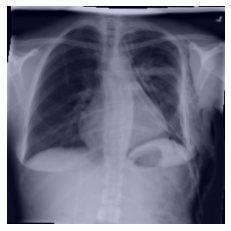


Image and mask shapes: torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
Patient ID: ed386e07-da6b-479a-b0db-a1a40f9bd068
Image scale: 0.0 - 0.9764705896377563
Target mask scale: 0.0 - 0.0


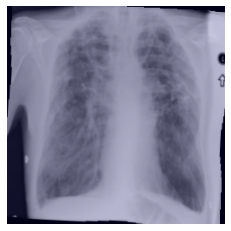


Image and mask shapes: torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
Patient ID: c801ebd5-8032-473d-8a47-de337f59c904
Image scale: 0.0 - 0.9450980424880981
Target mask scale: 0.0 - 1.0


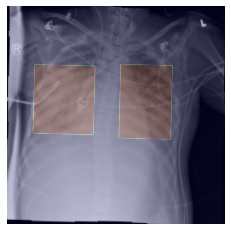


Image and mask shapes: torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
Patient ID: 99ee2e4b-87c3-499c-8e9f-47c6777e60e6
Image scale: 0.0 - 0.9764705896377563
Target mask scale: 0.0 - 0.0


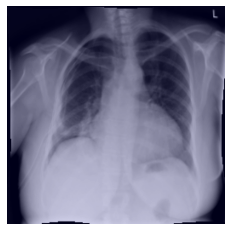


Image and mask shapes: torch.Size([1, 256, 256]) torch.Size([1, 256, 256])
Patient ID: d8adf370-83b9-4852-bedd-6e180fb95d9b
Image scale: 0.0 - 0.9960784316062927
Target mask scale: 0.0 - 0.0


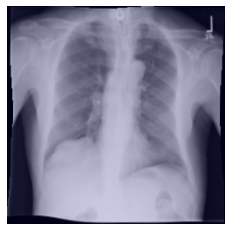

In [12]:
print('{} images in train set, {} images in validation set, and {} images in test set.'.format(len(dataset_train),
                                                                                               len(dataset_valid),
                                                                                               len(dataset_test)))
img_batch, target_batch, pId_batch = next(iter(loader_train))
print('Tensor batch size:', img_batch.size())

# 查看几个例子
for i in np.random.choice(len(dataset_train), size=5, replace=False):
    img, target, pId = dataset_train[i] 
    print('\nImage and mask shapes:', img.shape, target.shape)
    print('Patient ID:', pId)
    print('Image scale: {} - {}'.format(img[0].min(), img[0].max()))
    print('Target mask scale: {} - {}'.format(target[0].min(), target[0].max()))
    plt.imshow(img[0], cmap=mpl.cm.gist_gray) 
    plt.imshow(target[0], cmap=mpl.cm.jet, alpha=0.2)
    plt.axis('off')
    plt.show()

Image shape: torch.Size([1, 256, 256])
Patient ID: 2ac2f354-ae86-4c87-9ed7-38c842c6e604
Image scale: 0.0 - 1.0


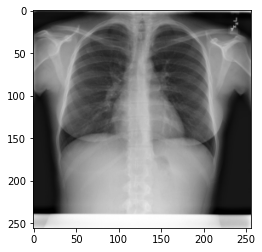

In [13]:
# 查看是否加载
img, pId = dataset_test[0] 
print('Image shape:', img.shape)
print('Patient ID:', pId)
print('Image scale: {} - {}'.format(img[0].min(), img[0].max()))
plt.imshow(img[0], cmap=mpl.cm.gist_gray) 

In [14]:
# 定义nn卷积块
class conv_block(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True,
                 bn_momentum=0.9, alpha_leaky=0.03):
        super(conv_block, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size,
                              stride=stride, padding=padding, bias=bias)
        self.bn = nn.BatchNorm2d(out_channels, eps=1e-05, momentum=bn_momentum,affine=True)
        self.activ = nn.LeakyReLU(negative_slope=alpha_leaky)

    def forward(self, x):
        return self.activ(self.bn(self.conv(x)))
    
# 定义nn转置卷积块
class conv_t_block(nn.Module):
    """
    Define the [convolution_transpose - batch normalization - activation] block 
    """

    def __init__(self, in_channels, out_channels, output_size=None, kernel_size=3, bias=True,
                 bn_momentum=0.9, alpha_leaky=0.03):
        super(conv_t_block, self).__init__()
        self.conv_t = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=2, padding=1, 
                                         bias=bias)
        self.bn = nn.BatchNorm2d(out_channels, eps=1e-05, momentum=bn_momentum,affine=True)
        self.activ = nn.LeakyReLU(negative_slope=alpha_leaky)

    def forward(self, x, output_size):
        return self.activ(self.bn(self.conv_t(x, output_size=output_size)))

In [15]:
# 定义model
class PneumoniaUNET(nn.Module):

    def __init__(self):
        super(PneumoniaUNET, self).__init__()
        
        self.down_1 = nn.Sequential(conv_block(in_channels=1, out_channels=64), conv_block(in_channels=64, out_channels=64))
        self.down_2 = nn.Sequential(conv_block(in_channels=64, out_channels=128), conv_block(in_channels=128, out_channels=128))
        self.down_3 = nn.Sequential(conv_block(in_channels=128, out_channels=256), conv_block(in_channels=256, out_channels=256))
        self.down_4 = nn.Sequential(conv_block(in_channels=256, out_channels=512), conv_block(in_channels=512, out_channels=512))
        self.down_5 = nn.Sequential(conv_block(in_channels=512, out_channels=512), conv_block(in_channels=512, out_channels=512))

        self.middle = nn.Sequential(conv_block(in_channels=512, out_channels=512), conv_block(in_channels=512, out_channels=512))
        self.middle_t = conv_t_block(in_channels=512, out_channels=256)

        self.up_5 = nn.Sequential(conv_block(in_channels=768, out_channels=512), conv_block(in_channels=512, out_channels=512))
        self.up_5_t = conv_t_block(in_channels=512, out_channels=256)
        self.up_4 = nn.Sequential(conv_block(in_channels=768, out_channels=512), conv_block(in_channels=512, out_channels=512))
        self.up_4_t = conv_t_block(in_channels=512, out_channels=128)
        self.up_3 = nn.Sequential(conv_block(in_channels=384, out_channels=256), conv_block(in_channels=256, out_channels=256))
        self.up_3_t = conv_t_block(in_channels=256, out_channels=64)
        self.up_2 = nn.Sequential(conv_block(in_channels=192, out_channels=128), conv_block(in_channels=128, out_channels=128))
        self.up_2_t = conv_t_block(in_channels=128, out_channels=32)
        self.up_1 = nn.Sequential(conv_block(in_channels=96, out_channels=64), conv_block(in_channels=64, out_channels=1))
        
    def forward(self, x):
        down1 = self.down_1(x) # (1x256x256 -> 64x256x256)
        out = F.max_pool2d(down1, kernel_size=2, stride=2) # (64x256x256 -> 64x128x128)

        down2 = self.down_2(out) # (64x128x128 -> 128x128x128)
        out = F.max_pool2d(down2, kernel_size=2, stride=2) # (128x128x128 -> 128x64x64)

        down3 = self.down_3(out) # (128x64x64 -> 256x64x64)
        out = F.max_pool2d(down3, kernel_size=2, stride=2) # (256x64x64 -> 256x32x32)

        down4 = self.down_4(out) # (256x32x32 -> 512x32x32)
        out = F.max_pool2d(down4, kernel_size=2, stride=2) # (512x32x32 -> 512x16x16)

        down5 = self.down_5(out) # (512x16x16 -> 512x16x16)
        out = F.max_pool2d(down5, kernel_size=2, stride=2) # (512x16x16 -> 512x8x8)

        out = self.middle(out) # (512x8x8 -> 512x8x8)
        out = self.middle_t(out, output_size=down5.size()) # (512x8x8 -> 256x16x16)

        out = torch.cat([down5, out], 1) # (512x16x16-concat-256x16x16 -> 768x16x16)
        out = self.up_5(out) # (768x16x16 -> 512x16x16)
        out = self.up_5_t(out, output_size=down4.size()) # (512x16x16 -> 256x32x32)

        out = torch.cat([down4, out], 1) # (512x32x32-concat-256x32x32 -> 768x32x32)
        out = self.up_4(out) # (768x32x32 -> 512x32x32)
        out = self.up_4_t(out, output_size=down3.size()) # (512x32x32 -> 128x64x64)
        
        out = torch.cat([down3, out], 1) # (256x64x64-concat-128x64x64 -> 384x64x64)
        out = self.up_3(out) # (384x64x64 -> 256x64x64)
        out = self.up_3_t(out, output_size=down2.size()) # (256x64x64 -> 64x128x128)
        
        out = torch.cat([down2, out], 1) # (128x128x128-concat-64x128x128 -> 192x128x128)
        out = self.up_2(out) # (192x128x128 -> 128x128x128)
        out = self.up_2_t(out, output_size=down1.size()) # (128x128x128 -> 32x256x256)
        
        out = torch.cat([down1, out], 1) # (64x256x256-concat-32x256x256 -> 96x256x256)
        out = self.up_1(out) # (96x256x256 -> 1x256x256)
        
        return out

In [16]:
# 打印model
print(PneumoniaUNET())

PneumoniaUNET(
  (down_1): Sequential(
    (0): conv_block(
      (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (activ): LeakyReLU(negative_slope=0.03)
    )
    (1): conv_block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (activ): LeakyReLU(negative_slope=0.03)
    )
  )
  (down_2): Sequential(
    (0): conv_block(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (activ): LeakyReLU(negative_slope=0.03)
    )
    (1): conv_block(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
 

In [17]:
# 损失函数sigmod与交叉熵
class BCEWithLogitsLoss2d(nn.Module):

    def __init__(self, weight=None, size_average=True):
        super(BCEWithLogitsLoss2d, self).__init__()
        self.loss = nn.BCEWithLogitsLoss(weight, size_average)

    def forward(self, scores, targets):
        scores_flat = scores.view(-1)
        targets_flat = targets.view(-1)
        return self.loss(scores_flat, targets_flat)

In [19]:
# 定义辅助函数创建遮罩
def box_mask(box, shape=1024):
#rray of bool) mask as binary 2D array
    x, y, w, h = box
    mask = np.zeros((shape, shape), dtype=bool)
    mask[y:y+h, x:x+w] = True 
    return mask


# 定义从预测掩码中提取框的置信度和坐标的函数
def parse_boxes(msk, threshold=0.20, connectivity=None):


    msk = msk[0]
    pos = np.zeros(msk.shape)
    pos[msk>threshold] = 1.
    lbl = skimage.measure.label(pos, connectivity=connectivity)
    
    predicted_boxes = []
    confidences = []
    for region in skimage.measure.regionprops(lbl):
        y1, x1, y2, x2 = region.bbox
        h = y2 - y1
        w = x2 - x1
        c = np.nanmean(msk[y1:y2, x1:x2])
        if w*h > min_box_area: 
            predicted_boxes.append([x1, y1, w, h])
            confidences.append(c)
    
    return predicted_boxes, confidences


# 创建字符函数
def prediction_string(predicted_boxes, confidences):
    prediction_string = ''
    for c, box in zip(confidences, predicted_boxes):
        prediction_string += ' ' + str(c) + ' ' + ' '.join([str(b) for b in box])
    return prediction_string[1:]   

# iou
def IoU(pr, gt):
    IoU = (pr & gt).sum() / ((pr | gt).sum() + 1.e-9)
    return IoU

# 定义精度函数
def precision(tp, fp, fn):
    return float(tp) / (tp + fp + fn + 1.e-9)


# 图像平均精度
def average_precision_image(predicted_boxes, confidences, target_boxes, shape=1024):
    if predicted_boxes == [] and target_boxes == []:
        return np.nan
    else:
        if len(predicted_boxes)>0 and target_boxes == []:
            return 0.0
        elif len(target_boxes)>0 and predicted_boxes == []:
            return 0.0
        else:
            thresholds = np.arange(0.4, 0.8, 0.05) 
            predicted_boxes_sorted = list(reversed([b for _, b in sorted(zip(confidences, predicted_boxes), 
                                                                         key=lambda pair: pair[0])]))            
            average_precision = 0.0
            for t in thresholds: 
                tp = 0 
                fp = len(predicted_boxes) 
                for box_p in predicted_boxes_sorted: 
                    box_p_msk = box_mask(box_p, shape) 
                    for box_t in target_boxes: 
                        box_t_msk = box_mask(box_t, shape) 
                        iou = IoU(box_p_msk, box_t_msk) 
                        if iou>t:
                            tp += 1 
                            fp -= 1 
                            break 
                fn = len(target_boxes)
                for box_t in target_boxes: 
                    box_t_msk = box_mask(box_t, shape) 
                    for box_p in predicted_boxes_sorted: 
                        box_p_msk = box_mask(box_p, shape) 
                        iou = IoU(box_p_msk, box_t_msk) 
                        if iou>t:
                            fn -= 1
                            break
                average_precision += precision(tp, fp, fn) / float(len(thresholds))
            return average_precision


# 计算batch平均精度
def average_precision_batch(output_batch, pIds, pId_boxes_dict, rescale_factor, shape=1024, return_array=False):
    
    batch_precisions = []
    for msk, pId in zip(output_batch, pIds):
        target_boxes = pId_boxes_dict[pId] if pId in pId_boxes_dict else []
        if len(target_boxes)>0:
            target_boxes = [[int(round(c/float(rescale_factor))) for c in box_t] for box_t in target_boxes]
        predicted_boxes, confidences = parse_boxes(msk) 
        batch_precisions.append(average_precision_image(predicted_boxes, confidences, target_boxes, shape=shape))
    if return_array:
        return np.asarray(batch_precisions)
    else:
        return np.nanmean(np.asarray(batch_precisions)) 

In [20]:
class RunningAverage():
    def __init__(self):
        self.steps = 0
        self.total = 0
    
    def update(self, val):
        self.total += val
        self.steps += 1
    
    def __call__(self):
        return self.total/float(self.steps)

In [21]:
def save_checkpoint(state, is_best, metric):
    filename = 'last.pth.tar'
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, metric+'.best.pth.tar')

In [22]:
# tarin
def train(model, dataloader, optimizer, loss_fn, num_steps, pId_boxes_dict, rescale_factor, shape, save_summary_steps=5):
    model.train()

    summary = []
    loss_avg = RunningAverage()

    loss_avg_t_hist_ep, loss_t_hist_ep, prec_t_hist_ep = [], [], []
    start = time.time()        
    
    for i, (input_batch, labels_batch, pIds_batch) in enumerate(dataloader):
        if i > num_steps:
            break
        input_batch = Variable(input_batch).cuda() if gpu_available else Variable(input_batch).float()
        labels_batch = Variable(labels_batch).cuda() if gpu_available else Variable(labels_batch).float()
            
        optimizer.zero_grad()
        output_batch = model(input_batch)

        loss = loss_fn(output_batch, labels_batch)

        loss.backward()
        optimizer.step()

        loss_avg.update(loss.item())
        loss_t_hist_ep.append(loss.item())
        loss_avg_t_hist_ep.append(loss_avg())

        if i % save_summary_steps == 0:
            output_batch = output_batch.data.cpu().numpy()
            prec_batch = average_precision_batch(output_batch, pIds_batch, pId_boxes_dict, rescale_factor, shape)
            prec_t_hist_ep.append(prec_batch)
            summary_batch_string = "batch loss = {:05.7f} ;  ".format(loss.item())
            summary_batch_string += "average loss = {:05.7f} ;  ".format(loss_avg())
            summary_batch_string += "batch precision = {:05.7f} ;  ".format(prec_batch)
            print('--- Train batch {} / {}: '.format(i, num_steps) + summary_batch_string)
            delta_time = time.time() - start
            print('    {} batches processed in {:.2f} seconds'.format(save_summary_steps, delta_time))
            start = time.time()

    metrics_string = "average loss = {:05.7f} ;  ".format(loss_avg())
    print("- Train epoch metrics summary: " + metrics_string)
    
    return loss_avg_t_hist_ep, loss_t_hist_ep, prec_t_hist_ep

In [23]:
def evaluate(model, dataloader, loss_fn, num_steps, pId_boxes_dict, rescale_factor, shape):

    model.eval()

    losses = []
    precisions = []

    start = time.time()
    for i, (input_batch, labels_batch, pIds_batch) in enumerate(dataloader):
        if i > num_steps:
            break
        input_batch = Variable(input_batch).cuda() if gpu_available else Variable(input_batch).float()
        labels_batch = Variable(labels_batch).cuda() if gpu_available else Variable(labels_batch).float()

        output_batch = model(input_batch)
        loss = loss_fn(output_batch, labels_batch)
        losses.append(loss.item())

        output_batch = output_batch.data.cpu()
        prec_batch = average_precision_batch(output_batch, pIds_batch, pId_boxes_dict, rescale_factor, shape, return_array=True)
        for p in prec_batch:
            precisions.append(p)
        print('--- Validation batch {} / {}: '.format(i, num_steps))

    metrics_mean = {'loss' : np.nanmean(losses),
                    'precision' : np.nanmean(np.asarray(precisions))}
    metrics_string = "average loss = {:05.7f} ;  ".format(metrics_mean['loss'])
    metrics_string += "average precision = {:05.7f} ;  ".format(metrics_mean['precision'])
    print("- Eval metrics : " + metrics_string)
    delta_time = time.time() - start
    print('  Evaluation run in {:.2f} seconds.'.format(delta_time))
    
    return metrics_mean

In [24]:
def train_and_evaluate(model, train_dataloader, val_dataloader, lr_init, loss_fn, num_epochs, 
                       num_steps_train, num_steps_eval, pId_boxes_dict, rescale_factor, shape, restore_file=None):

    if restore_file is not None:
        checkpoint = torch.load(restore_file)
        model.load_state_dict(checkpoint['state_dict'])
            
    best_val_loss = 1e+15
    best_val_prec = 0.0
    best_loss_model = None
    best_prec_model = None

    loss_t_history = []
    loss_v_history = []
    loss_avg_t_history = []
    prec_t_history = []
    prec_v_history = []

    for epoch in range(num_epochs):
        start = time.time()
        
        lr = lr_init * 0.5**float(epoch)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        print("Epoch {}/{}. Learning rate = {:05.3f}.".format(epoch + 1, num_epochs, lr))

        loss_avg_t_hist_ep, loss_t_hist_ep, prec_t_hist_ep = train(model, train_dataloader, optimizer, loss_fn, 
                                                                   num_steps_train, pId_boxes_dict, rescale_factor, shape)
        loss_avg_t_history += loss_avg_t_hist_ep
        loss_t_history += loss_t_hist_ep
        prec_t_history += prec_t_hist_ep
        
        val_metrics = evaluate(model, val_dataloader, loss_fn, num_steps_eval, pId_boxes_dict, rescale_factor, shape)

        val_loss = val_metrics['loss']
        val_prec = val_metrics['precision']
        
        loss_v_history += len(loss_t_hist_ep) * [val_loss]
        prec_v_history += len(prec_t_hist_ep) * [val_prec]

        is_best_loss = val_loss<=best_val_loss
        is_best_prec = val_prec>=best_val_prec
        
        if is_best_loss:
            print("- Found new best loss: {:.4f}".format(val_loss))
            best_val_loss = val_loss
            best_loss_model = model
        if is_best_prec:
            print("- Found new best precision: {:.4f}".format(val_prec))
            best_val_prec = val_prec
            best_prec_model = model
            
        save_checkpoint({'epoch': epoch + 1,
                         'state_dict': model.state_dict(),
                         'optim_dict' : optimizer.state_dict()},
                         is_best=is_best_loss,
                         metric='loss')
        save_checkpoint({'epoch': epoch + 1,
                         'state_dict': model.state_dict(),
                         'optim_dict' : optimizer.state_dict()},
                         is_best=is_best_prec,
                         metric='prec')
        
        delta_time = time.time() - start
        print('Epoch run in {:.2f} minutes'.format(delta_time/60.))

    histories = {'loss avg train' : loss_avg_t_history,
                 'loss train' : loss_t_history,
                 'precision train' : prec_t_history,
                 'loss validation' : loss_v_history, 
                 'precision validation' : prec_v_history}
    best_models = {'best loss model' : best_loss_model,
                   'best precision model' : best_prec_model}
    
    return histories, best_models

In [25]:
def predict(model, dataloader): 
    model.eval()
    
    predictions = {}

    for i, (test_batch, pIds) in enumerate(dataloader):
        print('Predicting batch {} / {}.'.format(i+1, len(dataloader)))
        test_batch = Variable(test_batch).cuda() if gpu_available else Variable(test_batch).float()
            
        output_batch = model(test_batch)
        sig = nn.Sigmoid().cuda()
        output_batch = sig(output_batch)
        output_batch = output_batch.data.cpu().numpy()
        for pId, output in zip(pIds, output_batch):
            predictions[pId] = output
        
    return predictions

In [27]:
model = PneumoniaUNET().cuda()
loss_fn = BCEWithLogitsLoss2d().cuda()
lr_init = 0.5

In [28]:
num_epochs = 1 
num_steps_train = len(loader_train)
num_steps_eval = len(loader_valid)

shape = int(round(original_image_shape / rescale_factor))

# Train the model
print("Starting training for {} epochs".format(num_epochs))
histories, best_models = train_and_evaluate(model, loader_train, loader_valid, lr_init, loss_fn, 
                                            num_epochs, num_steps_train, num_steps_eval, pId_boxes_dict, rescale_factor, shape)

idation batch 156 / 756: 
--- Validation batch 157 / 756: 
--- Validation batch 158 / 756: 
--- Validation batch 159 / 756: 
--- Validation batch 160 / 756: 
--- Validation batch 161 / 756: 
--- Validation batch 162 / 756: 
--- Validation batch 163 / 756: 
--- Validation batch 164 / 756: 
--- Validation batch 165 / 756: 
--- Validation batch 166 / 756: 
--- Validation batch 167 / 756: 
--- Validation batch 168 / 756: 
--- Validation batch 169 / 756: 
--- Validation batch 170 / 756: 
--- Validation batch 171 / 756: 
--- Validation batch 172 / 756: 
--- Validation batch 173 / 756: 
--- Validation batch 174 / 756: 
--- Validation batch 175 / 756: 
--- Validation batch 176 / 756: 
--- Validation batch 177 / 756: 
--- Validation batch 178 / 756: 
--- Validation batch 179 / 756: 
--- Validation batch 180 / 756: 
--- Validation batch 181 / 756: 
--- Validation batch 182 / 756: 
--- Validation batch 183 / 756: 
--- Validation batch 184 / 756: 
--- Validation batch 185 / 756: 
--- Validation ba

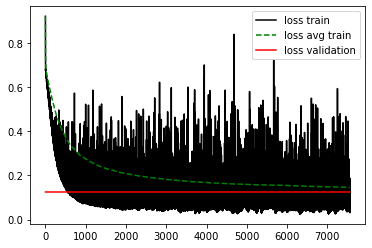

In [30]:
# 打印训练过程
plt.plot(range(len(histories['loss train'])), histories['loss train'], color='k', label='loss train')
plt.plot(range(len(histories['loss avg train'])), histories['loss avg train'], color='g', ls='dashed', label='loss avg train')
plt.plot(range(len(histories['loss validation'])), histories['loss validation'], color='r', label='loss validation')
plt.legend()

In [32]:
# 从训练中找到最好的模型
best_model = best_models['best precision model']

In [33]:
# 验证集准确度
dataset_valid = PneumoniaDataset(root=datapath_orig, subset='train', pIds=pIds_valid, predict=True, 
                                 boxes=None, rescale_factor=rescale_factor, transform=transform)
loader_valid = DataLoader(dataset=dataset_valid,
                          batch_size=batch_size,
                          shuffle=False) 

predictions_valid = predict(best_model, loader_valid)
print('Predicted {} validation images.'.format(len(predictions_valid)))

56.
Predicting batch 42 / 756.
Predicting batch 43 / 756.
Predicting batch 44 / 756.
Predicting batch 45 / 756.
Predicting batch 46 / 756.
Predicting batch 47 / 756.
Predicting batch 48 / 756.
Predicting batch 49 / 756.
Predicting batch 50 / 756.
Predicting batch 51 / 756.
Predicting batch 52 / 756.
Predicting batch 53 / 756.
Predicting batch 54 / 756.
Predicting batch 55 / 756.
Predicting batch 56 / 756.
Predicting batch 57 / 756.
Predicting batch 58 / 756.
Predicting batch 59 / 756.
Predicting batch 60 / 756.
Predicting batch 61 / 756.
Predicting batch 62 / 756.
Predicting batch 63 / 756.
Predicting batch 64 / 756.
Predicting batch 65 / 756.
Predicting batch 66 / 756.
Predicting batch 67 / 756.
Predicting batch 68 / 756.
Predicting batch 69 / 756.
Predicting batch 70 / 756.
Predicting batch 71 / 756.
Predicting batch 72 / 756.
Predicting batch 73 / 756.
Predicting batch 74 / 756.
Predicting batch 75 / 756.
Predicting batch 76 / 756.
Predicting batch 77 / 756.
Predicting batch 78 / 75

In [34]:
def rescale_box_coordinates(box, rescale_factor):
    x, y, w, h = box
    x = int(round(x/rescale_factor))
    y = int(round(y/rescale_factor))
    w = int(round(w/rescale_factor))
    h = int(round(h/rescale_factor))
    return [x, y, w, h]  

In [35]:
def draw_boxes(predicted_boxes, confidences, target_boxes, ax, angle=0):
    if len(predicted_boxes)>0:
        for box, c in zip(predicted_boxes, confidences):
            # extracting individual coordinates
            x, y, w, h = box 
            # create a rectangle patch
            patch = Rectangle((x,y), w, h, color='red', ls='dashed',
                              angle=angle, fill=False, lw=4, joinstyle='round', alpha=0.6)
            # get current axis and draw rectangle
            ax.add_patch(patch)
            # add confidence value in annotation text
            ax.text(x+w/2., y-5, '{:.2}'.format(c), color='red', size=20, va='center', ha='center')
    if len(target_boxes)>0:
        for box in target_boxes:
            # rescale and extract box coordinates
            x, y, w, h = box
            # create a rectangle patch
            patch = Rectangle((x,y), w, h, color='red',  
                              angle=angle, fill=False, lw=4, joinstyle='round', alpha=0.6)
            # get current axis and draw rectangle
            ax.add_patch(patch)
    
    return ax

In [38]:
# grid search
best_threshold = None
best_avg_precision_valid = 0.0
thresholds = np.arange(0.01, 0.60, 0.01)
avg_precision_valids = []
for threshold in thresholds:
    precision_valid = []
    for i in range(len(dataset_valid)):
        img, pId = dataset_valid[i]
        target_boxes = [rescale_box_coordinates(box, rescale_factor) for box in pId_boxes_dict[pId]] if pId in pId_boxes_dict else []
        prediction = predictions_valid[pId]
        predicted_boxes, confidences = parse_boxes(prediction, threshold=threshold, connectivity=None)
        avg_precision_img = average_precision_image(predicted_boxes, confidences, target_boxes, shape=img[0].shape[0])
        precision_valid.append(avg_precision_img)
    avg_precision_valid = np.nanmean(precision_valid)
    avg_precision_valids.append(avg_precision_valid)
    print('Threshold: {}, average precision validation: {:03.5f}'.format(threshold, avg_precision_valid))
    if avg_precision_valid>best_avg_precision_valid:
        print('Found new best average precision validation!')
        best_avg_precision_valid = avg_precision_valid
        best_threshold = threshold
plt.plot(thresholds, avg_precision_valids)

Threshold: 0.01, average precision validation: 0.00079
Found new best average precision validation!
Threshold: 0.02, average precision validation: 0.00316
Found new best average precision validation!
Threshold: 0.03, average precision validation: 0.00510
Found new best average precision validation!
Threshold: 0.04, average precision validation: 0.00880
Found new best average precision validation!
Threshold: 0.05, average precision validation: 0.01281
Found new best average precision validation!


Prediction mask scale: 0.0020130745 - 0.175034
Prediction string: 0.16106686 62 121 32 43
Ground truth boxes: []
Average precision image: 0.00000


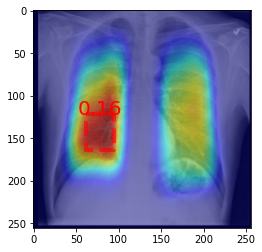

Prediction mask scale: 0.0019474188 - 0.17939425
Prediction string: 0.16509408 50 85 58 79 0.16310848 150 93 60 63
Ground truth boxes: []
Average precision image: 0.00000


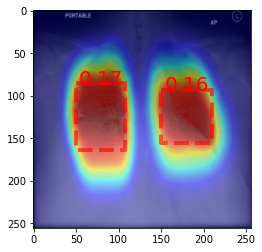

Prediction mask scale: 0.0019576384 - 0.17926176
Prediction string: 0.16369829 47 69 59 153 0.16411988 141 75 61 135
Ground truth boxes: []
Average precision image: 0.00000


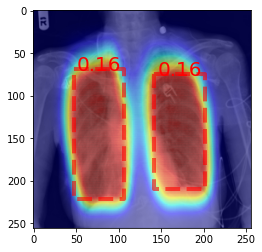

Prediction mask scale: 0.0019538149 - 0.17882778
Prediction string: 0.16745773 53 71 53 125 0.16436715 155 78 48 126
Ground truth boxes: []
Average precision image: 0.00000


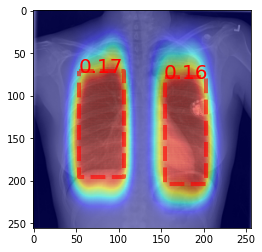

Prediction mask scale: 0.0019527477 - 0.17797026
Prediction string: 0.16471079 133 87 51 73 0.15993436 47 107 45 47
Ground truth boxes: []
Average precision image: 0.00000


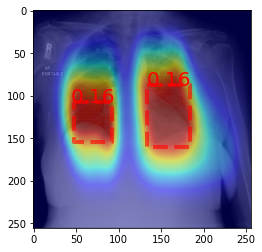

Prediction mask scale: 0.0019600964 - 0.17926477
Prediction string: 0.16546112 34 75 57 105 0.16564147 127 75 61 133
Ground truth boxes: []
Average precision image: 0.00000


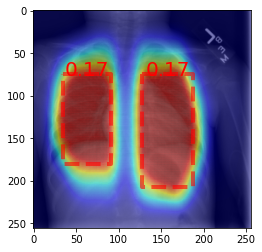

Prediction mask scale: 0.0019756933 - 0.17854653
Prediction string: 0.16434295 156 89 52 63 0.1659431 55 97 41 55
Ground truth boxes: []
Average precision image: 0.00000


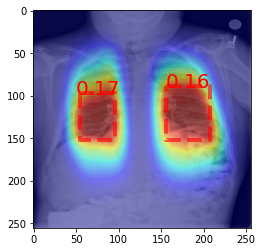

Prediction mask scale: 0.0019424916 - 0.1777762
Prediction string: 0.16434066 65 67 44 73 0.16304429 173 79 39 71
Ground truth boxes: []
Average precision image: 0.00000


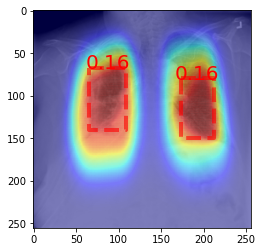

Prediction mask scale: 0.0019413419 - 0.18025282
Prediction string: 0.16534367 65 55 70 129 0.16684389 152 62 62 126
Ground truth boxes: [[81, 100, 46, 45], [163, 85, 44, 68]]
Average precision image: 0.00000


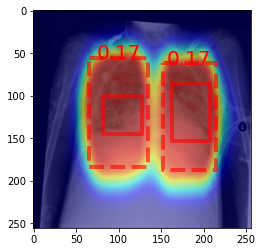

Prediction mask scale: 0.0019540836 - 0.15635107
Prediction string: 
Ground truth boxes: []
Average precision image: 00nan


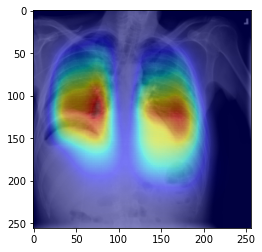

Prediction mask scale: 0.002014742 - 0.1766085
Prediction string: 0.15681577 150 63 67 105 0.16417998 51 79 51 87
Ground truth boxes: []
Average precision image: 0.00000


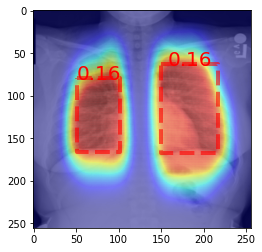

Prediction mask scale: 0.0019537767 - 0.1781848
Prediction string: 0.16320433 65 117 41 63
Ground truth boxes: []
Average precision image: 0.00000


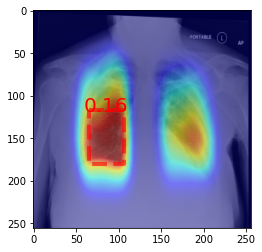

Prediction mask scale: 0.001950915 - 0.17606105
Prediction string: 0.16090392 62 103 42 51
Ground truth boxes: []
Average precision image: 0.00000


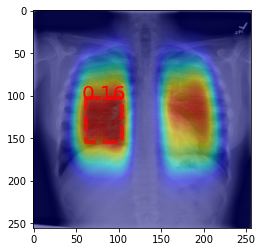

Prediction mask scale: 0.0019673393 - 0.18016857
Prediction string: 0.16821828 27 48 65 160 0.16223027 130 75 69 125
Ground truth boxes: [[34, 117, 46, 60]]
Average precision image: 0.00000


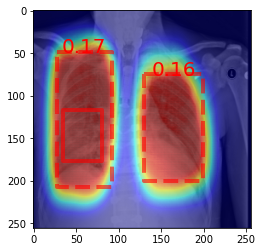

Prediction mask scale: 0.001972668 - 0.17165814
Prediction string: 0.16030814 88 85 24 69
Ground truth boxes: []
Average precision image: 0.00000


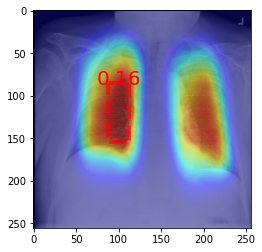

Prediction mask scale: 0.0019721217 - 0.1743097
Prediction string: 0.16112924 78 115 23 59
Ground truth boxes: []
Average precision image: 0.00000


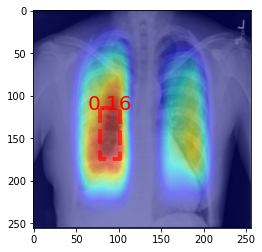

Prediction mask scale: 0.0019988033 - 0.18000224
Prediction string: 0.166516 30 101 41 91 0.16101417 121 121 51 57
Ground truth boxes: []
Average precision image: 0.00000


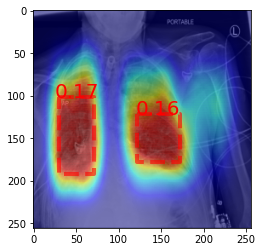

Prediction mask scale: 0.001957721 - 0.17843474
Prediction string: 0.1642333 142 85 59 119 0.1639065 47 89 46 97
Ground truth boxes: [[152, 105, 48, 104], [21, 92, 66, 83]]
Average precision image: 0.50000


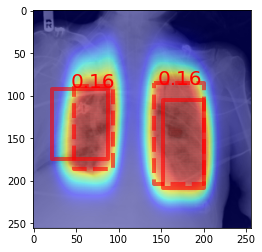

Prediction mask scale: 0.001947428 - 0.1765676
Prediction string: 0.16491656 88 105 24 58
Ground truth boxes: []
Average precision image: 0.00000


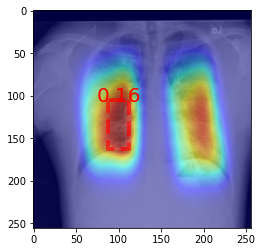

Prediction mask scale: 0.0019429447 - 0.1794806
Prediction string: 0.16528857 53 65 58 127 0.16486274 152 85 61 105
Ground truth boxes: [[163, 158, 39, 36], [60, 165, 35, 28]]
Average precision image: 0.00000


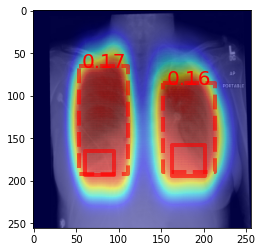

Prediction mask scale: 0.001956652 - 0.17589407
Prediction string: 0.16530658 63 77 47 75
Ground truth boxes: []
Average precision image: 0.00000


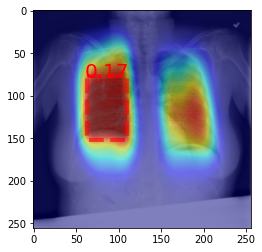

Prediction mask scale: 0.0019467773 - 0.17881446
Prediction string: 0.16693509 153 59 55 109 0.16512977 59 70 49 102
Ground truth boxes: []
Average precision image: 0.00000


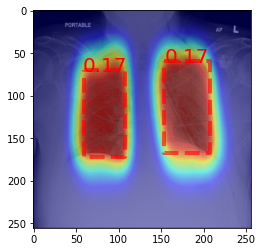

Prediction mask scale: 0.0019461076 - 0.1775681
Prediction string: 0.15550108 159 71 54 95
Ground truth boxes: [[158, 64, 26, 40]]
Average precision image: 0.00000


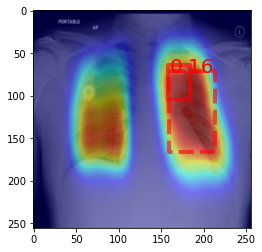

Prediction mask scale: 0.0019425201 - 0.18013065
Prediction string: 0.16622576 59 77 50 129 0.16331528 158 109 48 91
Ground truth boxes: []
Average precision image: 0.00000


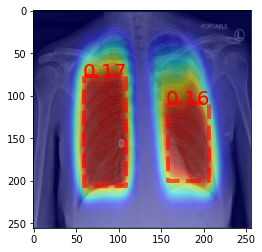

Prediction mask scale: 0.0019528833 - 0.17200512
Prediction string: 0.16056417 61 65 40 39
Ground truth boxes: []
Average precision image: 0.00000


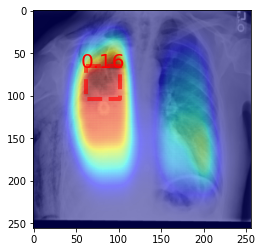

Prediction mask scale: 0.0019469684 - 0.17977218
Prediction string: 0.16597386 67 83 52 82 0.15996332 162 107 48 83
Ground truth boxes: [[67, 134, 42, 24]]
Average precision image: 0.00000


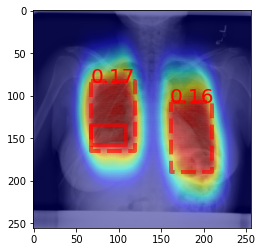

Prediction mask scale: 0.0019421328 - 0.18031192
Prediction string: 0.16460669 137 71 74 117 0.16621494 51 77 63 127
Ground truth boxes: [[58, 137, 46, 63], [137, 118, 75, 78]]
Average precision image: 0.16667


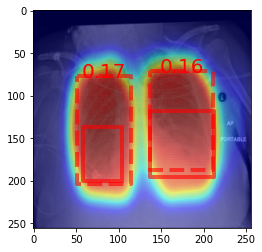

Prediction mask scale: 0.0019431574 - 0.17875473
Prediction string: 0.16276333 150 97 58 75 0.16567649 50 105 57 89
Ground truth boxes: []
Average precision image: 0.00000


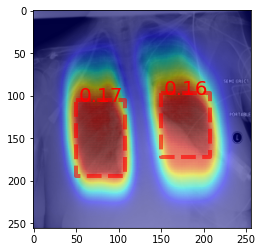

Prediction mask scale: 0.0019420608 - 0.15444188
Prediction string: 
Ground truth boxes: []
Average precision image: 00nan


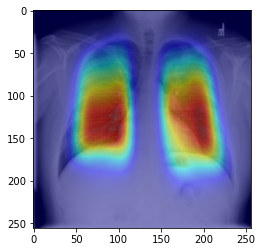

Prediction mask scale: 0.0021922449 - 0.17902781
Prediction string: 0.16207193 145 45 78 157 0.16418973 48 77 59 93
Ground truth boxes: []
Average precision image: 0.00000


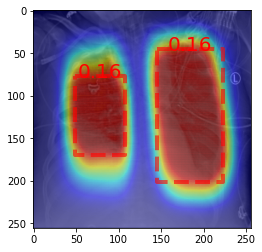

Prediction mask scale: 0.0019494143 - 0.10806422
Prediction string: 
Ground truth boxes: []
Average precision image: 00nan


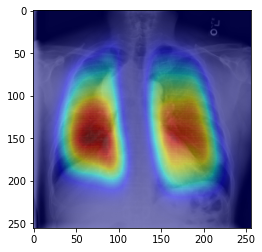

In [37]:
for i in range(len(dataset_valid)):
    img, pId = dataset_valid[i]
    target_boxes = [rescale_box_coordinates(box, rescale_factor) for box in pId_boxes_dict[pId]] if pId in pId_boxes_dict else []
    prediction = predictions_valid[pId]
    predicted_boxes, confidences = parse_boxes(prediction, threshold=best_threshold, connectivity=None)
    avg_precision_img = average_precision_image(predicted_boxes, confidences, target_boxes, shape=img[0].shape[0])
    if i%100==0: 
        plt.imshow(img[0], cmap=mpl.cm.gist_gray) 
        plt.imshow(prediction[0], cmap=mpl.cm.jet, alpha=0.5)
        draw_boxes(predicted_boxes, confidences, target_boxes, plt.gca())
        print('Prediction mask scale:', prediction[0].min(), '-', prediction[0].max())
        print('Prediction string:', prediction_string(predicted_boxes, confidences))
        print('Ground truth boxes:', target_boxes)
        print('Average precision image: {:05.5f}'.format(avg_precision_img))
        plt.show()

In [ ]:
predictions_test = predict(best_model, loader_test)

此处得到最优模型后，可以test数据进行预测，但由于时间原因，不再考察在无label的test上的结果，而且因为肉眼无法看出病灶，结果也无法说明任何问题。